# Nerual Networks on Spend Behaviour

In this notebook, we will:

- Load 2 preprocessed datasets (no missing values).
- Perform basic exploratory analysis.
- Do feature engineering and categorical encoding.
- Apply multiple clustering algorithms on spend-related features:
  - K-Means
  - Hierarchical clustering
  - DBSCAN
- Systematically loop over hyperparameters, generate plots, and store results.

The main variable of interest is `spend_category`, and we’ll engineer and encode features suitable for unsupervised clustering.


In [10]:
# standard libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# display & style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

## Data Loading

We define a helper function that:
- Reads a CSV given a path.
- Prints basic info for sanity checks.


In [11]:
def load_dataset(path: str, name: str = "dataset"):
    assert os.path.exists(path), f"File not found: {path}"
    df = pd.read_csv(path)
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nData types:")
    print(df.dtypes)
    # print("\nSample rows:")
    # display(df.head())
    return df

dataset_dir = Path.cwd().parent / "datasets" / "preprocessed"
train = load_dataset(dataset_dir.joinpath("train_preprocessed.csv"), "train")
test = load_dataset(dataset_dir.joinpath("test_preprocessed.csv"), "test")


=== train ===
Shape: (10492, 22)
Columns: ['trip_id', 'country', 'age_group', 'travel_companions', 'num_females', 'num_males', 'main_activity', 'visit_purpose', 'is_first_visit', 'mainland_stay_nights', 'island_stay_nights', 'tour_type', 'intl_transport_included', 'info_source', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'total_trip_days', 'spend_category']

Data types:
trip_id                         object
country                         object
age_group                       object
travel_companions               object
num_females                    float64
num_males                      float64
main_activity                   object
visit_purpose                   object
is_first_visit                  object
mainland_stay_nights             int64
island_stay_nights               int64
tour_type                       object
intl_transport_included         object
info_source              

## 1. Feature Engineering for Neural Networks

Neural Networks require careful data preparation. Unlike tree models, they cannot handle raw categories strings. Unlike SVMs, simple One-Hot Encoding can be inefficient for high-cardinality features.

**Our Strategy:**
1.  **Numerical Features:** We will standard-scale features like `total_people`, `total_nights` to ensure gradients flow smoothly.
2.  **Categorical Features:** We will use **Entity Embeddings**. This means we map each category (e.g., "Mexico") to a dense vector of numbers that the network learns.
3.  **Target Encoding:** We ensure our target `spend_category` is encoded as integers (0, 1, 2).

We create a custom pipeline to handle these transformations separately.

In [12]:
# --- 2. Initial Cleanup & Interaction Features ---
# (Same logic as before, essential for any model)
def basic_engineering(df):
    df = df.copy()
    
    # Clean typos
    if 'main_activity' in df.columns:
        df['main_activity'] = df['main_activity'].replace('Widlife Tourism', 'Wildlife Tourism')
    
    # Interaction Features
    df['total_people'] = df['num_females'] + df['num_males']
    df['total_nights'] = df['mainland_stay_nights'] + df['island_stay_nights']
    
    # Avoid division by zero for ratios
    df['island_ratio'] = df.apply(
        lambda x: x['island_stay_nights'] / x['total_nights'] if x['total_nights'] > 0 else 0, 
        axis=1
    )
    
    # Drop IDs and raw columns we replaced
    drop_cols = ['trip_id', 'num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    return df

train_df = basic_engineering(train)
test_df = basic_engineering(test)

# Separate Target
y = train_df['spend_category'].values
X = train_df.drop(columns=['spend_category'])
X_test = test_df.copy()

# --- 3. Preprocessing for Neural Networks ---
# We need to treat Categorical and Numerical columns differently

# A. Categorical Columns (High Cardinality -> Embeddings)
cat_cols = ['country', 'age_group', 'travel_companions', 'main_activity', 'visit_purpose', 
            'tour_type', 'info_source', 'total_trip_days'] # Add any other object cols

# B. Binary/Low Cardinality (Can just be 0/1)
binary_cols = ['is_first_visit', 'intl_transport_included', 'accomodation_included', 
               'food_included', 'domestic_transport_included', 'sightseeing_included', 
               'guide_included', 'insurance_included']

# C. Numerical Columns
num_cols = ['total_people', 'total_nights', 'island_ratio']

# --- 4. Apply Encodings ---
# Dictionary to store encoders so we can transform Test data identically
cat_encoders = {} 

def process_data(df, is_train=True):
    processed = {}
    
    # 1. Numerics: Standard Scaling
    # For simplicity here, we assume simple standardization. 
    # In production, fit scaler on train and transform test.
    for col in num_cols:
        # Fill NaNs just in case
        df[col] = df[col].fillna(df[col].median())
        
        if is_train:
            scaler = StandardScaler()
            processed[col] = scaler.fit_transform(df[[col]]).flatten()
            cat_encoders[f'scaler_{col}'] = scaler
        else:
            scaler = cat_encoders[f'scaler_{col}']
            processed[col] = scaler.transform(df[[col]]).flatten()

    # 2. Categoricals: Label Encoding (for Embeddings later)
    for col in cat_cols:
        df[col] = df[col].astype(str) # Ensure string
        if is_train:
            le = LabelEncoder()
            # Handle unknown classes by appending 'Unknown'
            unique_vals = list(df[col].unique()) + ['Unknown']
            le.fit(unique_vals)
            processed[col] = le.transform(df[col])
            cat_encoders[f'le_{col}'] = le
        else:
            le = cat_encoders[f'le_{col}']
            # Map unseen labels to 'Unknown'
            df[col] = df[col].map(lambda s: s if s in le.classes_ else 'Unknown')
            processed[col] = le.transform(df[col])
            
    # 3. Binaries: Simple Map
    for col in binary_cols:
        processed[col] = df[col].map({'Yes': 1, 'No': 0}).fillna(0).astype(int).values
        
    return pd.DataFrame(processed)

# Process both sets
X_train_proc = process_data(X, is_train=True)
X_test_proc = process_data(X_test, is_train=False)

print("Processed Train Shape:", X_train_proc.shape)
print("Processed Test Shape:", X_test_proc.shape)
X_train_proc.head()

Processed Train Shape: (10492, 19)
Processed Test Shape: (5852, 19)


,total_people,total_nights,island_ratio,country,age_group,travel_companions,main_activity,visit_purpose,tour_type,info_source,total_trip_days,is_first_visit,intl_transport_included,accomodation_included,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included
0,0.475269,-0.306795,2.141300,37,2,5,0,1,0,3,2,1,0,0,0,0,0,0,0
1,-0.478907,-0.371776,-0.656997,52,2,0,3,3,0,4,2,1,0,0,0,0,0,0,0
2,-0.001819,-0.371776,0.275769,96,1,3,4,3,0,0,2,0,0,0,0,0,0,0,0
3,-0.001819,-0.306795,2.141300,48,1,4,0,1,1,7,3,1,1,1,1,0,0,0,0
4,-0.001819,-0.631699,-0.656997,120,1,3,9,0,0,3,3,1,0,0,0,0,0,0,0


## 2. Neural Network Architecture & Hyperparameter Tuning

We use the Keras **Functional API** to build a "two-headed" network:
1.  **Embedding Branch:** Each categorical feature (e.g., `country`) gets its own Embedding Layer. This allows the model to learn dense vector representations of categories (learning that "USA" and "Canada" are similar).
2.  **Numerical Branch:** Numerical features are fed directly into the network.

These branches are concatenated and passed through a series of Dense layers.

**Hyperparameter Search:**
We loop through different configurations to optimize:
* **Units:** The number of neurons in the hidden layers (Capacity).
* **Dropout:** The probability of dropping neurons to prevent overfitting.
* **Learning Rate:** How large the gradient descent steps are.

We use **EarlyStopping** to automatically stop training when the model stops improving, saving time and preventing overfitting.

Starting Neural Network Grid Search...

Testing Configuration: {'units': 128, 'dropout': 0.3, 'lr': 0.001}
  -> Best Validation Accuracy: 0.7575

Testing Configuration: {'units': 256, 'dropout': 0.3, 'lr': 0.001}
  -> Best Validation Accuracy: 0.7580

Testing Configuration: {'units': 128, 'dropout': 0.5, 'lr': 0.0005}
  -> Best Validation Accuracy: 0.7527

WINNER: {'units': 256, 'dropout': 0.3, 'lr': 0.001} with Accuracy: 0.7580


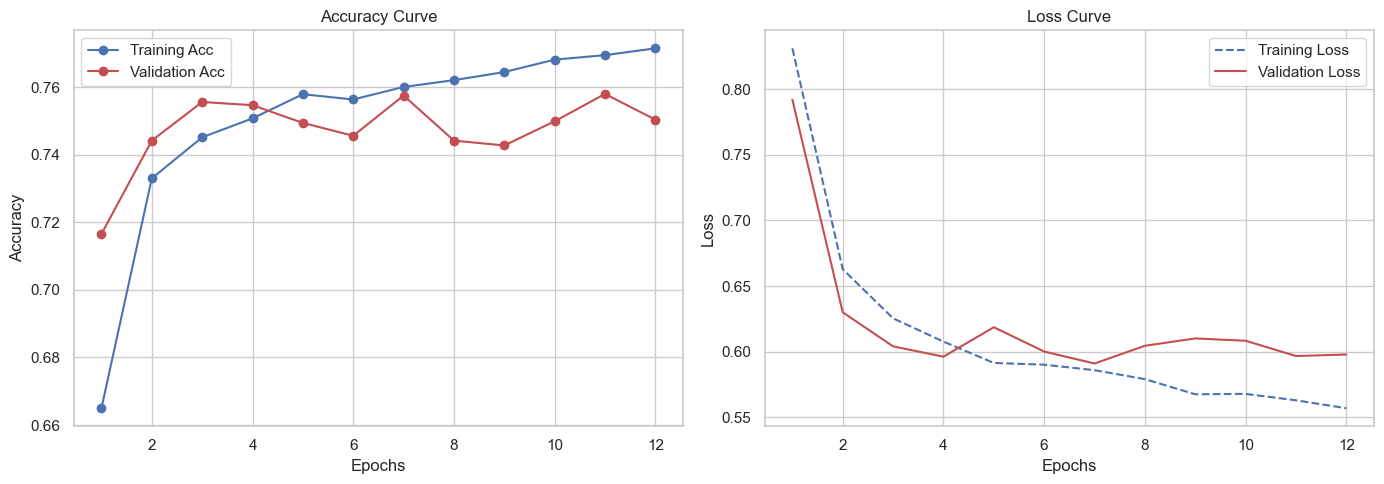

In [14]:
# --- 1. Data Preparation for Functional API ---
# Keras needs a list of arrays: [Cat1_Array, Cat2_Array, ..., CatN_Array, Numerical_Matrix]
def get_keras_inputs(df, cat_cols, num_cols):
    inputs = []
    # 1. Categorical Inputs (One array per column)
    for col in cat_cols:
        inputs.append(df[col].values)
    
    # 2. Numerical Inputs (One matrix for all)
    inputs.append(df[num_cols].values)
    return inputs

# Prepare inputs
X_train_inputs = get_keras_inputs(X_train_proc, cat_cols, num_cols)
# Target
y_train_labels = y

# --- 2. Model Builder Function ---
def build_model(hp_units, hp_dropout, hp_lr):
    inputs_list = []
    embeddings = []
    
    # A. Define Embedding Input Layers
    for col in cat_cols:
        # Input for single integer (category index)
        input_cat = layers.Input(shape=(1,), name=f"in_{col}")
        inputs_list.append(input_cat)
        
        # Determine embedding dimension (Rule of thumb: min(50, unique/2))
        n_unique = X_train_proc[col].nunique()
        embed_dim = min(50, (n_unique // 2) + 1)
        
        # Embedding Layer
        emb = layers.Embedding(input_dim=n_unique + 1, output_dim=embed_dim, name=f"emb_{col}")(input_cat)
        emb = layers.Flatten()(emb) # Flatten to 1D vector
        embeddings.append(emb)
        
    # B. Define Numerical Input Layer
    input_num = layers.Input(shape=(len(num_cols),), name="in_numerics")
    inputs_list.append(input_num)
    
    # C. Concatenate All Features
    x = layers.Concatenate()(embeddings + [input_num])
    
    # D. Dense Layers (The "Brain")
    # Layer 1
    x = layers.Dense(hp_units, activation='relu')(x)
    x = layers.BatchNormalization()(x) # Stabilizes training
    x = layers.Dropout(hp_dropout)(x)  # Prevents overfitting
    
    # Layer 2 (Half the size)
    x = layers.Dense(hp_units // 2, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp_dropout)(x)
    
    # Output Layer (3 Classes: 0, 1, 2)
    output = layers.Dense(3, activation='softmax', name="output")(x)
    
    # Compile
    model = models.Model(inputs=inputs_list, outputs=output)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp_lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 3. Hyperparameter Tuning Loop ---
# Define our search space
param_grid = [
    {'units': 128, 'dropout': 0.3, 'lr': 0.001},
    {'units': 256, 'dropout': 0.3, 'lr': 0.001},
    {'units': 128, 'dropout': 0.5, 'lr': 0.0005}, # High regularization
]

best_val_acc = 0
best_model = None
best_history = None
best_params = {}

print("Starting Neural Network Grid Search...")

for params in param_grid:
    print(f"\nTesting Configuration: {params}")
    
    model = build_model(params['units'], params['dropout'], params['lr'])
    
    # Early Stopping: Stop if val_loss doesn't improve for 5 epochs
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train_inputs, y_train_labels,
        validation_split=0.2, # Hold out 20% for validation
        epochs=30,            # Max epochs (ES will stop it earlier)
        batch_size=32,
        callbacks=[es],
        verbose=0             # Silent training
    )
    
    # Get best validation accuracy from this run
    val_acc = max(history.history['val_accuracy'])
    print(f"  -> Best Validation Accuracy: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_history = history
        best_params = params

print(f"\nWINNER: {best_params} with Accuracy: {best_val_acc:.4f}")

# --- 4. Visualize Performance ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(epochs, acc, 'bo-', label='Training Acc')
    ax1.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    ax1.set_title('Accuracy Curve')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(epochs, loss, 'b--', label='Training Loss')
    ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax2.set_title('Loss Curve')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

if best_history:
    plot_history(best_history)

## 3. Retraining & Submission

Now that we have found the best hyperparameters (stored in `best_params`), we should:
1.  **Retrain on Full Data:** We essentially "wasted" 20% of our data for validation during the tuning phase. For the final submission, we want the model to learn from **100% of the training data** to maximize performance.
2.  **Process Test Data:** We apply the same input formatting (`get_keras_inputs`) to the test set.
3.  **Generate Predictions:** The model outputs probabilities (e.g., `[0.1, 0.8, 0.1]`). We use `argmax` to convert this into the predicted class (e.g., `1`).
4.  **Save CSV:** We format the results into the competition's required structure.

Retraining model on full dataset with params: {'units': 256, 'dropout': 0.3, 'lr': 0.001}...
Epoch 1/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6704 - loss: 0.8221
Epoch 2/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7260 - loss: 0.6681
Epoch 3/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7429 - loss: 0.6277
Epoch 4/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7495 - loss: 0.6058
Epoch 5/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7572 - loss: 0.5960
Epoch 6/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7600 - loss: 0.5895
Epoch 7/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7600 - loss: 0.5788
Epoch 8/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7593 - loss: 0.5812
Epoch 9/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7632 - loss: 0.5708
Epoch 10/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7633 - loss: 0.5753
Epoch 11/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

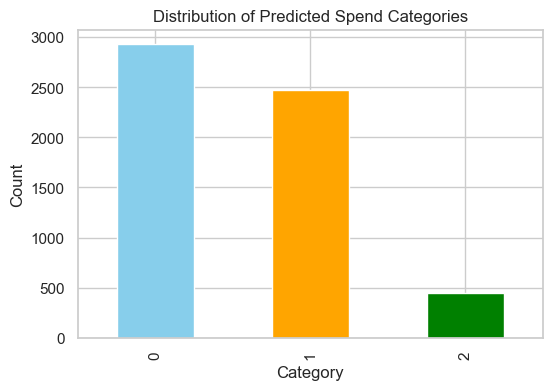

In [15]:
# --- 1. Retrain on Full Data ---
print(f"Retraining model on full dataset with params: {best_params}...")

# Re-build model with best hyperparameters
final_model = build_model(
    hp_units=best_params['units'],
    hp_dropout=best_params['dropout'],
    hp_lr=best_params['lr']
)

# Train on ALL data (no validation split this time)
final_history = final_model.fit(
    X_train_inputs, y_train_labels,
    epochs=30, # Use the same number of epochs as determined efficient
    batch_size=32,
    verbose=1
)

# --- 2. Prepare Test Data ---
# Convert the preprocessed test dataframe into the list-of-arrays format
X_test_inputs = get_keras_inputs(X_test_proc, cat_cols, num_cols)

# --- 3. Generate Predictions ---
print("\nPredicting on Test Data...")
test_probs = final_model.predict(X_test_inputs)

# Convert probabilities to class labels (0, 1, or 2)
# axis=1 finds the index of the highest probability in each row
test_preds = np.argmax(test_probs, axis=1)

# --- 4. Create Submission File ---
submission = pd.DataFrame({
    'trip_id': test['trip_id'], # Ensure we use the original trip_ids
    'spend_category': test_preds
})

# Save
filename = "submission_neural_network.csv"
submission.to_csv(filename, index=False)

print(f"\nSaved submission to: {filename}")
print(f"Shape: {submission.shape}")
print("\nFirst 5 predictions:")
print(submission.head())

# Optional: Visualize prediction distribution
plt.figure(figsize=(6, 4))
submission['spend_category'].value_counts().sort_index().plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title('Distribution of Predicted Spend Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()